# Transform 2021 NLP demo by Anne Estoppey [comment]

## Introduction
In this notebook we will work with Wellbore report summaries from Norwegian Petroleum Directorate (NPD). The wellbore datasets are public domain.<br> They are available here: https://hotell.difi.no/?dataset=npd/wellbore/with-history (well report summaries).<br> The following link should go to all data available from Norwegian Oil Directorate, in public domain: https://data.norge.no/datasets/4304aea1-53b1-47ed-beae-52bf4d3642f3 (link might get broken over time).<br>
We will explore different NLP methods to extract insights and also create a few visualisations.
#### UNDER CONSTRUCTION, CHECK FOR UPDATES! :-)) <<<< remember to remove [comment]

#### How to fix blank maps and graph in jupyter lab!!
Check out link here: https://stackoverflow.com/questions/54936125/plotly-gives-an-empty-field-as-output-in-jupyter-lab <br>
To check if your jupyter lab plotly extension is up un running: > jupyter labextension list
#### Requirements
Python version: Python 3.7.4 <br>
You will need this version of pyLDAvis for the topics visualisation: pyLDAvis 2.1.2

# Worth saying that pyLDAvis is from pip and not conda [comment]
# also talk about installing spacy, just point to docs [comment]

---

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import re, os, operator
import collections 
import matplotlib.pyplot as plt
import requests
import json

import geopandas as gpd

import nltk
nltk.download('stopwords', download_dir='/home/geodev/anaconda3/envs/nlp_test/nltk_data')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import spacy # spacy - text comprehension package

# gensim - topic modeling package
import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
#%matplotlib inline # no longer needed in notebook
import plotly.express as px

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/geodev/anaconda3/envs/nlp_test/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import warnings
warnings.filterwarnings('ignore')
# added this as I get the following warning throughout, you won't as you're on python 3.7 I think

/home/geodev/anaconda3/envs/nlp_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# way too many rows for a demo [comment]

In [3]:
# set max number of rows for pandas
pd.set_option('display.max_rows', 2000)

#### API connection - check for status
Make a general get request, print out status code. 
Status code = 200 means API connection is up and running.

In [4]:
requests.get('https://data.norge.no/api/dcat/870917732/data.json')

<Response [200]>

#### Get request - Well summaries
The datasets are paginated. The first page will tell us how many pages there are in total, and how many rows for the whole dataset.

In [5]:
wells_summary = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-history?page=1')
json_wells_summary = wells_summary.json()
print(f'number of pages: {json_wells_summary["pages"]}')
print(f'number of rows:  {json_wells_summary["posts"]}')

number of pages: 19
number of rows:  1824


#### Let's go through all the pages and append all the rows in JSON dictionary
Create a pandas dataframe from the json file

In [6]:
def get_all_data(url_dataset, df_out_name):
    '''getting number of pages,
    looping through all pages,
    append in JSON dictionary,
    create dataframe
    '''
    wells_summary = requests.get(url_dataset)
    json_count_page = wells_summary.json()
    
    page = json_count_page['pages']
    all_data_list = []
    for i in range(0, page):
        url = url_dataset + f'?page={i+1}'
        dataset_all = requests.get(url)
        dataset_all_json = dataset_all.json()
        number_of_entries = len(dataset_all_json['entries'])

        for entry in range(0, number_of_entries):
            all_data_list.append(dataset_all_json['entries'][entry])

    df_out_name = pd.DataFrame(all_data_list)
    return df_out_name

#### Getting all our well summaries into a dataframe

In [7]:
url_dataset ='https://hotell.difi.no/api/json/npd/wellbore/with-history'
df_out_name = 'df_all_summaries'
# json_count_page = json_wells_summary  # total number of pages (pagination)
df_all_summaries = get_all_data(url_dataset, df_out_name)

In [8]:
df_all_summaries.shape

(1824, 5)

In [9]:
df_all_summaries.head()

wlbHistoryDateUpdated   wlbName wlbNPDID_wellbore  \
0   7/6/2016 12:00:00 AM     1/2-1              1382   
1  4/11/2017 12:00:00 AM     1/2-2              5192   
2  5/19/2016 12:00:00 AM     1/3-1               154   
3  4/11/2017 12:00:00 AM    1/3-10              5614   
4  4/11/2017 12:00:00 AM  1/3-10 A              5779   

                                          wlbHistory datesyncNPD  
0  <p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...  19.03.2021  
1  <p>The 1/2-2 well was drilled to evaluate the ...  19.03.2021  
2  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021  
3  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021  
4  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021

In [10]:
# check for duplicate wells!
boolean = df_all_summaries['wlbName'].duplicated().any()
if boolean == True:
    pd.concat(g for _, g in df_all_summaries.groupby("wlbName") if len(g) > 1)
else:
    print("No duplicates!")

No duplicates!


#### Display a complete summary - we will need to clean all this html code!

# I like these headers throughout explaining what you do [comment]

In [11]:
# Display well summary (wlbHistory) 
df_all_summaries.iloc[1500]['wlbHistory']

'<p class=MsoBodyText><b><span lang=EN-GB>General</span></b></p>\n\n<p class=MsoBodyText><span lang=EN-GB>Well 6508/1-2 was drilled on the Skaugumsåsen\nprospect in the south-western end of the Helgeland Basin in the Norwegian Sea, about\nten kilometres south of the Norne field. The primary objective was to prove\npetroleum in reservoirs of the Early Jurassic Båt Group. A Secondary objective was\nto test the reservoir and HC potential of the Paleocene Tare Formation.</span></p>\n\n<p class=MsoBodyText><b><span lang=EN-GB>Operations and results</span></b></p>\n\n<p class=MsoBodyText><span lang=EN-GB>A 9 7/8&quot; pilot well 6508/1-U-2 was\ndrilled to 1305 m to check for shallow gas. No indications of shallow gas were\nseen. Wildcat well 6508/1-2 was spudded with the semi-submersible installation Aker\nBarents on 20 August 2011 and drilled to TD at 1810 m in the Early Jurassic\nTilje Formation. No significant problem was encountered in the operations. The\nwell was drilled with seawater 

#### Getting geolocation information for all wells - we will append this information to our well summary dataframe

In [12]:
wells_with_coordinates = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-coordinates?page=1')
json_wells_with_coordinates = wells_with_coordinates.json()
print(f'number of pages: {json_wells_with_coordinates["pages"]}')
print(f'number of rows:  {json_wells_with_coordinates["posts"]}')

number of pages: 85
number of rows:  8471


In [13]:
url_dataset = 'https://hotell.difi.no/api/json/npd/wellbore/with-coordinates'
df_out_name = 'df_all_with_coord'
# json_count_page = json_wells_with_coordinates  # total pagination number
df_all_with_coord = get_all_data(url_dataset, df_out_name)

In [14]:
df_all_with_coord.shape

(8471, 26)

In [15]:
df_all_with_coord.head()

wlbUtmZone  wlbWellType wlbEwDeg wlbEwCode wlbEntryDate wlbNsSec wlbEwMin  \
0         31  EXPLORATION        2         E   20.03.1989    15.07       28   
1         31  EXPLORATION        2         E   14.12.2005       32       29   
2         31        OTHER        2         E   09.05.2009    55.58       27   
3         31        OTHER        2         E   12.05.2009    56.95       27   
4         31        OTHER        2         E   12.05.2009    54.99       27   

  wlbEwSec wlbNsDecDeg wlbProductionLicence  ...   wlbEwUtm wlbNsMin  \
0     35.7   56.887519                  143  ...  468106.29       53   
1    47.66   56.992222               143 CS  ...  469410.10       59   
2     5.01   56.948772                  143  ...  466625.99       56   
3     7.69   56.949153                  143  ...  466671.62       56   
4     8.52   56.948608                  143  ...  466685.16       56   

  wlbWellboreName wlbContent            wlbDrillingOperator wlbEwDesDeg  \
0           1/2-1        OIL    Phillips Petroleum Norsk AS    2.476583   
1           1/2-2  OIL SHOWS     Paladin Resources Norge AS    2.496572   
2         1/2-U-1             ConocoPhillips Skandinavia AS    2.451392   
3         1/2-U-2             ConocoPhillips Skandinavia AS    2.452136   
4         1/2-U-3             ConocoPhillips Skandinavia AS    2.452367   

     wlbNsUtm wlbGeodeticDatum datesyncNPD wlbMainArea  
0  6305128.26             ED50  19.03.2021   NORTH SEA  
1  6316774.33             ED50  19.03.2021   NORTH SEA  
2  6311958.73             ED50  19.03.2021   NORTH SEA  
3  6312000.73             ED50  19.03.2021   NORTH SEA  
4  6311940.01             ED50  19.03.2021   NORTH SEA  

[5 rows x 26 columns]

# might be worth putting check for duplicates into a fct as you call it again here [comment]

In [16]:
# check for duplicate wells!
boolean = df_all_with_coord['wlbWellboreName'].duplicated().any()
if boolean == True:
    pd.concat(g for _, g in df_all_summaries.groupby("wlbWellboreName") if len(g) > 1)
else:
    print("No duplicates!")

No duplicates!


#### Having a quick check on a map with our dataframe with coordinates

In [17]:
df_all_with_coord['wlbNsDecDeg'] = df_all_with_coord['wlbNsDecDeg'].astype(float).round(3)
df_all_with_coord['wlbEwDesDeg'] = df_all_with_coord['wlbEwDesDeg'].astype(float).round(3)

In [18]:
df_all_with_coord.dtypes

wlbUtmZone               object
wlbWellType              object
wlbEwDeg                 object
wlbEwCode                object
wlbEntryDate             object
wlbNsSec                 object
wlbEwMin                 object
wlbEwSec                 object
wlbNsDecDeg             float64
wlbProductionLicence     object
wlbNsDeg                 object
wlbNpdidWellbore         object
wlbPurposePlanned        object
wlbField                 object
wlbNsCode                object
wlbCompletionDate        object
wlbEwUtm                 object
wlbNsMin                 object
wlbWellboreName          object
wlbContent               object
wlbDrillingOperator      object
wlbEwDesDeg             float64
wlbNsUtm                 object
wlbGeodeticDatum         object
datesyncNPD              object
wlbMainArea              object
dtype: object

#### Drawing scatter map function

In [19]:
def drawScatterMap(dataframe, colorColumn, title):
    fig = px.scatter_mapbox(dataframe, 
                            lat="wlbNsDecDeg", lon="wlbEwDesDeg", 
                            color=colorColumn, 
                            width=1000, height=1000, 
                            # color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
                            color_discrete_sequence=px.colors.qualitative.D3,
                            center={'lat':71, 'lon':20},
                            zoom=3, 
                            # mapbox_style="stamen-watercolor",
                            mapbox_style="carto-positron",
                            title=title
                            )


    return fig.show()

# Sure you will, but show the interactivity here [comment]

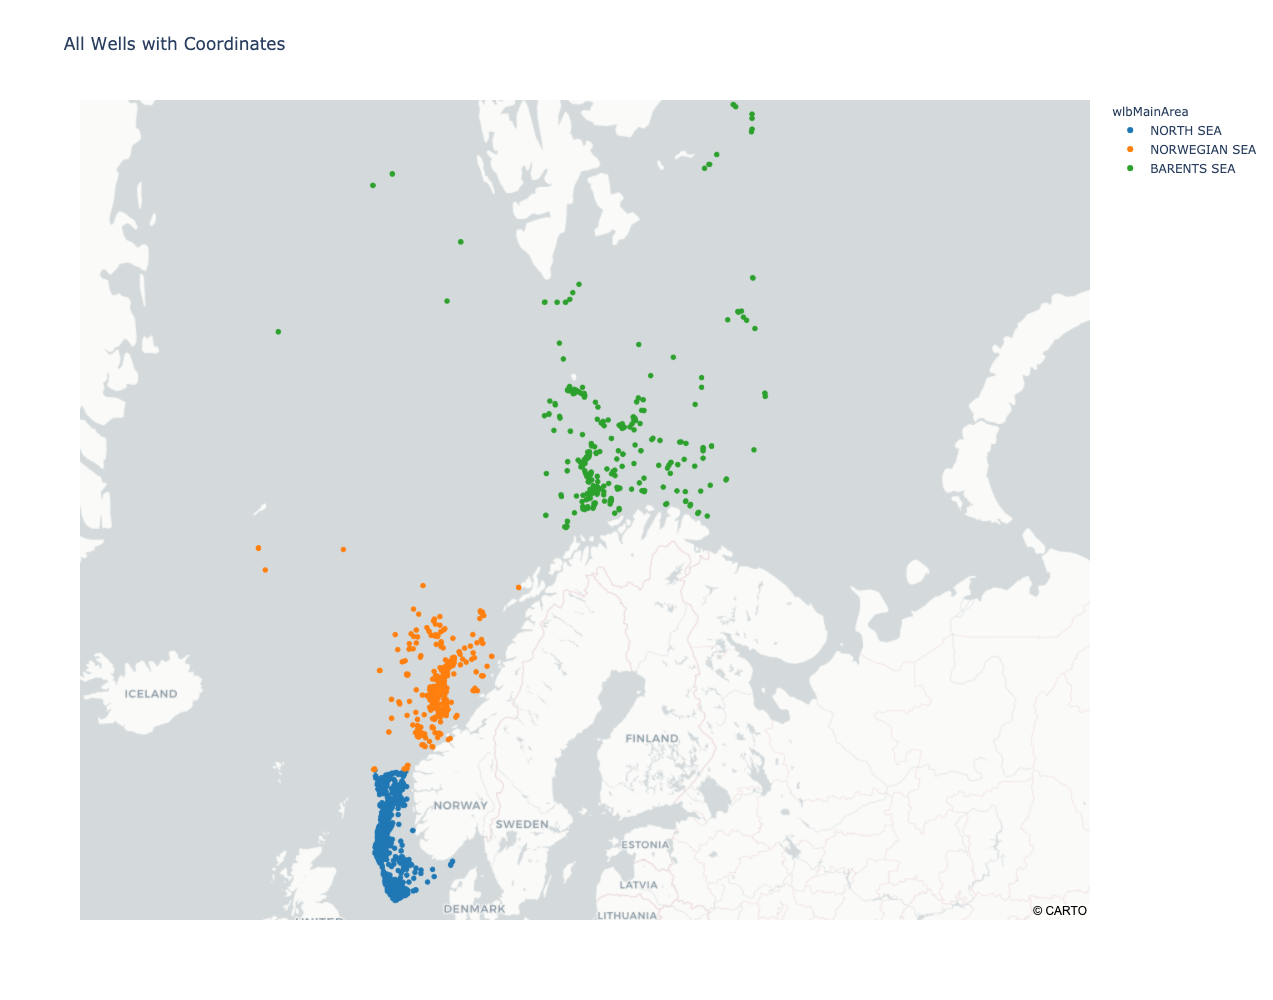

In [20]:
drawScatterMap(df_all_with_coord, 'wlbMainArea', 'All Wells with Coordinates')

In [21]:
df_all_with_coord.wlbMainArea.unique()

array(['NORTH SEA', 'NORWEGIAN SEA', 'BARENTS SEA'], dtype=object)

#### Merging df_all_with_coord together with df_all_summaries to get coordinates in the summary df

In [22]:
df_summaries_coord = pd.merge(df_all_summaries, 
                              df_all_with_coord[['wlbEwDesDeg', 'wlbNsDecDeg', 'wlbEwUtm', 'wlbNsUtm',
                                                   'wlbWellboreName', 'wlbContent', 'wlbMainArea', 'wlbDrillingOperator', 'wlbWellType']], how='left',
                              left_on='wlbName', right_on='wlbWellboreName')

In [23]:
df_summaries_coord.shape

(1824, 14)

In [24]:
df_summaries_coord.head()

wlbHistoryDateUpdated   wlbName wlbNPDID_wellbore  \
0   7/6/2016 12:00:00 AM     1/2-1              1382   
1  4/11/2017 12:00:00 AM     1/2-2              5192   
2  5/19/2016 12:00:00 AM     1/3-1               154   
3  4/11/2017 12:00:00 AM    1/3-10              5614   
4  4/11/2017 12:00:00 AM  1/3-10 A              5779   

                                          wlbHistory datesyncNPD  wlbEwDesDeg  \
0  <p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...  19.03.2021        2.477   
1  <p>The 1/2-2 well was drilled to evaluate the ...  19.03.2021        2.497   
2  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021        2.851   
3  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021        2.706   
4  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021        2.706   

   wlbNsDecDeg   wlbEwUtm    wlbNsUtm wlbWellboreName wlbContent wlbMainArea  \
0       56.888  468106.29  6305128.26           1/2-1        OIL   NORTH SEA   
1       56.992  469410.10  6316774.33           1/2-2  OIL SHOWS   NORTH SEA   
2       56.856  490936.87  6301488.86           1/3-1        GAS   NORTH SEA   
3       56.928  482089.29  6309521.94          1/3-10    OIL/GAS   NORTH SEA   
4       56.928  482089.29  6309521.94        1/3-10 A    OIL/GAS   NORTH SEA   

           wlbDrillingOperator  wlbWellType  
0  Phillips Petroleum Norsk AS  EXPLORATION  
1   Paladin Resources Norge AS  EXPLORATION  
2             A/S Norske Shell  EXPLORATION  
3            DONG E&P Norge AS  EXPLORATION  
4            DONG E&P Norge AS  EXPLORATION

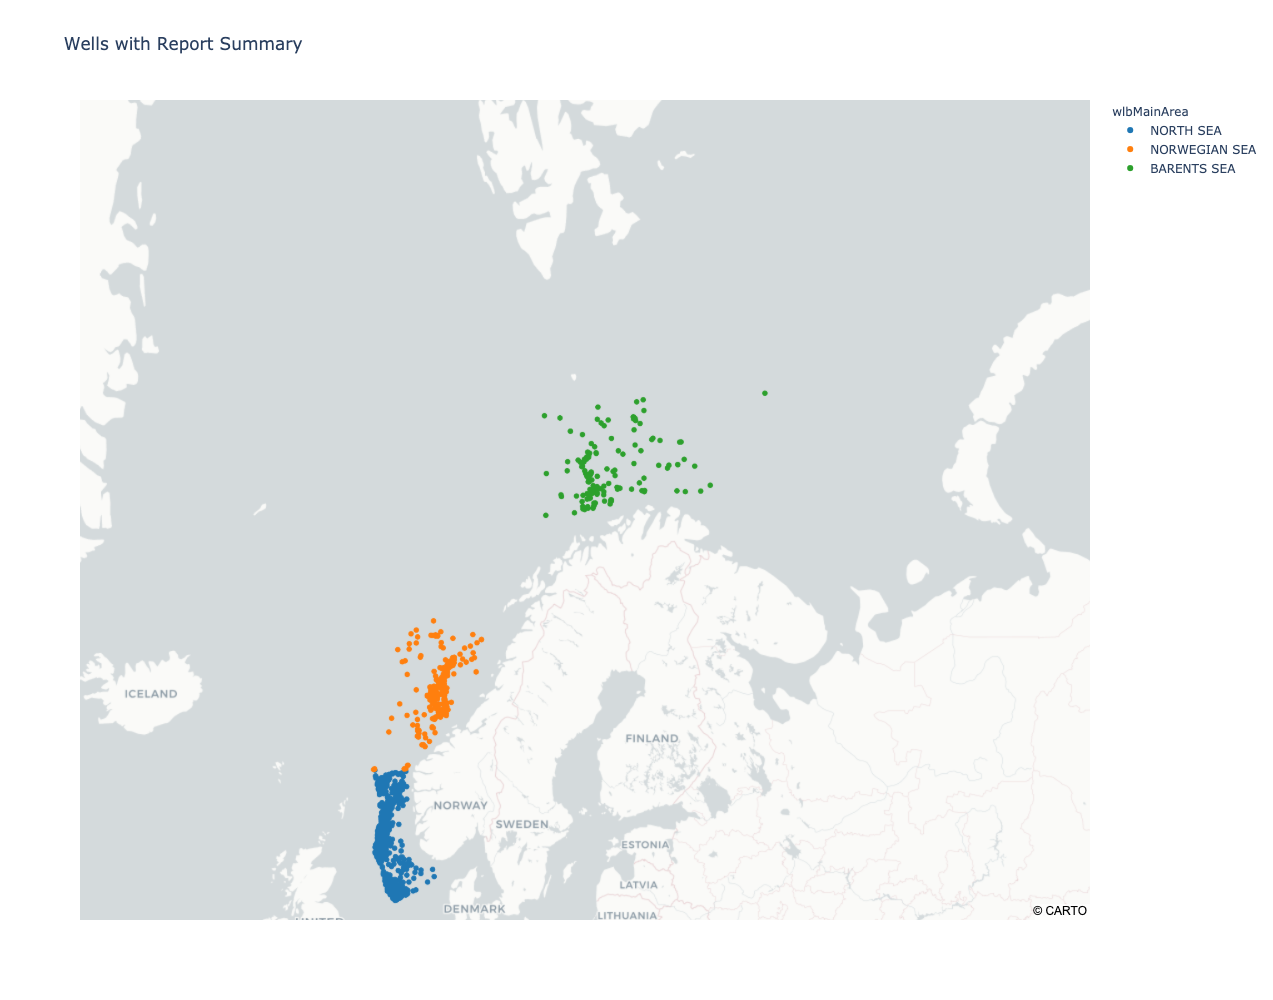

In [25]:
drawScatterMap(df_summaries_coord, 'wlbMainArea', 'Wells with Report Summary')

---

# not sure about the next line? use `code` style for variables to clean up [comment]

#### Removing tags from wlbHistory feature in df_summaries_coord + \n + replacing &quot with " with function 'cleanhtml'

In [26]:
# creating a copy of dataframe
df_summaries_coord_clean = df_summaries_coord.copy()
df_summaries_coord_clean.shape

(1824, 14)

In [27]:
# Basic cleaning of wlbHistory, we create new column 'wlbHistory_clean' with clean texts

def cleanhtml():
    # remove html tags
    cleanr = re.compile('<.*?>')
    
    rows = df_summaries_coord_clean['wlbHistory']
    listcleantext = []
    for r in rows:
        cleantext = re.sub(cleanr, '', r)
        
        # replace new line \n with empty space
        cleantext = cleantext.replace('\n', ' ')
        
        # replace &quot; with single quote (inch)
        cleantext = cleantext.replace('&quot;', "''")
        
        listcleantext.append(cleantext)
    df_summaries_coord_clean['wlbHistory_clean'] = listcleantext
    return

In [28]:
cleanhtml()

In [29]:
df_summaries_coord_clean.shape

(1824, 15)

# Not sure you nead `.head(20)`, hard to read and you want to limit scrolling as much as poss when presenting [comment]

In [30]:
df_summaries_coord_clean.head(20)

wlbHistoryDateUpdated   wlbName wlbNPDID_wellbore  \
0    7/6/2016 12:00:00 AM     1/2-1              1382   
1   4/11/2017 12:00:00 AM     1/2-2              5192   
2   5/19/2016 12:00:00 AM     1/3-1               154   
3   4/11/2017 12:00:00 AM    1/3-10              5614   
4   4/11/2017 12:00:00 AM  1/3-10 A              5779   
5   4/11/2017 12:00:00 AM    1/3-11              5806   
6   4/11/2017 12:00:00 AM  1/3-12 S              6260   
7   5/19/2016 12:00:00 AM     1/3-2               165   
8   5/19/2016 12:00:00 AM     1/3-3                87   
9   5/19/2016 12:00:00 AM     1/3-4                 2   
10   7/6/2016 12:00:00 AM     1/3-5               223   
11   7/6/2016 12:00:00 AM     1/3-6              1521   
12   7/6/2016 12:00:00 AM     1/3-7              2505   
13   7/6/2016 12:00:00 AM     1/3-8              2829   
14   7/6/2016 12:00:00 AM   1/3-9 S              3362   
15   7/6/2016 12:00:00 AM     1/5-1               237   
16   7/6/2016 12:00:00 AM     1/5-2               238   
17   7/6/2016 12:00:00 AM   1/5-3 S              3257   
18   7/6/2016 12:00:00 AM   1/5-4 S              4521   
19  3/16/2018 12:00:00 AM     1/5-5              7874   

                                           wlbHistory datesyncNPD  \
0   <p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...  19.03.2021   
1   <p>The 1/2-2 well was drilled to evaluate the ...  19.03.2021   
2   <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
3   <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
4   <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
5   <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
6   <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
7   <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
8   <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
9   <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
10  <p><b>General</b></p>\n\n<p>Well 1/3-5 was dri...  19.03.2021   
11  <p><b>General</b></p>\n\n<p>Well 1/3-6 is loca...  19.03.2021   
12  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
13  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
14  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
15  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
16  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   
17  <p><b>General</b></p>\n\n<p>Block 1/5 is situa...  19.03.2021   
18  <p><b>General</b></p>\n\n<p>The primary object...  19.03.2021   
19  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  19.03.2021   

    wlbEwDesDeg  wlbNsDecDeg   wlbEwUtm    wlbNsUtm wlbWellboreName  \
0         2.477       56.888  468106.29  6305128.26           1/2-1   
1         2.497       56.992  469410.10  6316774.33           1/2-2   
2         2.851       56.856  490936.87  6301488.86           1/3-1   
3         2.706       56.928  482089.29  6309521.94          1/3-10   
4         2.706       56.928  482089.29  6309521.94        1/3-10 A   
5         2.721       56.850  482979.33  6300817.06          1/3-11   
6         2.829       56.753  489529.49  6290057.13        1/3-12 S   
7         2.750       56.936  484786.28  6310443.20           1/3-2   
8         2.982       56.952  498885.66  6312226.32           1/3-3   
9         2.717       56.944  482765.43  6311354.32           1/3-4   
10        2.894       56.771  493528.57  6292053.66           1/3-5   
11        2.706       56.937  482095.98  6310606.04           1/3-6   
12        2.676       56.940  480302.33  6310930.49           1/3-7   
13        2.889       56.869  493238.84  6302911.22           1/3-8   
14        2.959       56.983  497490.00  6315610.11         1/3-9 S   
15        2.641       56.578  477951.01  6270600.43           1/5-1   
16        2.642       56.578  477994.36  6270633.90           1/5-2   
17        2.615       56.690  476419.16  6283101.44         1/5-3 S   
18     

In [31]:
rawtext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory']
# rawtext_sample

In [32]:
cleantext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory_clean']
# cleantext_sample

In [33]:
# counting words in string (simple count based on white space between words)
len(cleantext_sample.split())

689

---

### Pre-processing for NLP

# Here in next cell for example, but applies throughout, use markdown over comments to describe what you do, more legible [comment]

In [34]:
# We continue with our dataframe 'df_summaries_coord_clean'

In [35]:
# Average length of texts in wlbHistory_clean

print('Average wlbHistory length: ' + str(df_summaries_coord_clean["wlbHistory_clean"].str.split().str.len().mean()))

Average wlbHistory length: 408.2450657894737


In [36]:
# find index value for a given wlbName (this could be turned into a function to 'calculate' s1 and s2 parameters in cell below!)
# index_val = next(iter(df_summaries_coord_clean[df_summaries_coord_clean['wlbName']== '1/5-4 S'].index), 'no match')
# index_val

In [37]:
# Change all_text to list

wlbHistory_clean_to_list = df_summaries_coord_clean["wlbHistory_clean"].values.tolist()

# sample to analyse from the list
s1 = 10
s2 = 11

# pprint(wlbHistory_clean_to_list[:1])
pprint(wlbHistory_clean_to_list[s1:s2])

['General  Well 1/3-5 was drilled on a NW-SE oriented fault block tilted '
 'towards the NW. The structure is located in the northern Permian basin, on '
 'the east side of Central Graben, extending into blocks 116, 211, and 2/4. '
 'The purpose of the well was to evaluate the hydrocarbon potential of the '
 'Rotliegendes Group sandstones.  Operations and results  Wildcat well 1/3-5 '
 'was spudded with the 3-leg jack up installation Neddrill Trigon on 1 October '
 '1984 and drilled to TD at 4850 m in the Permian Rotliegendes Group. After '
 "setting the 30'' conductor a 14 3/4'' pilot hole was drilled to 1195 m, "
 "before opening the hole to 26''. Drilling to 2470 m the mud weight was "
 'raised from 1.33 g/cm3 to 1.70 g/cm3 due to high formation pressure. This '
 'resulted in tight hole during wiper trips, and high weight strain on the '
 "drill string, and also caused the 13 3/8'' casing to be set somewhat higher "
 'than prognosed. Through the chalk sequence the hole seemed to be 

In [38]:
# More cleaning

wlbHistory_clean_to_list2 = []

for sentence in range(0, len(wlbHistory_clean_to_list)):
    
    # Add spaces if two words appear to be concatenated by mistake
    # wlbHistory_ = re.sub(r'(\w)([A-Z])', r'\1 \2', str(wlbHistory_clean_to_list[sentence]))
    
    # Remove prefixed 'b', if present
    # wlbHistory_ = re.sub(r'^b\s+', '', wlbHistory_)
    
    # remove all numbers
    # wlbHistory_ = re.sub(r'\d+','', wlbHistory_)
    
    # Remove single characters from the start
    # wlbHistory_ = re.sub(r'\^[a-zA-Z]\s+', ' ', wlbHistory_)
    wlbHistory_ = re.sub(r'\^[a-zA-Z]\s+', ' ', str(wlbHistory_clean_to_list[sentence]))
    
    # Remove all the special characters
    wlbHistory_ = re.sub(r'\W', ' ', wlbHistory_)

    # Substituting multiple spaces with single space
    wlbHistory_ = re.sub(r'\s+', ' ', wlbHistory_, flags=re.I)

    wlbHistory_clean_to_list2.append(wlbHistory_)
    
pprint(wlbHistory_clean_to_list2[s1:s2])

['General Well 1 3 5 was drilled on a NW SE oriented fault block tilted '
 'towards the NW The structure is located in the northern Permian basin on the '
 'east side of Central Graben extending into blocks 116 211 and 2 4 The '
 'purpose of the well was to evaluate the hydrocarbon potential of the '
 'Rotliegendes Group sandstones Operations and results Wildcat well 1 3 5 was '
 'spudded with the 3 leg jack up installation Neddrill Trigon on 1 October '
 '1984 and drilled to TD at 4850 m in the Permian Rotliegendes Group After '
 'setting the 30 conductor a 14 3 4 pilot hole was drilled to 1195 m before '
 'opening the hole to 26 Drilling to 2470 m the mud weight was raised from 1 '
 '33 g cm3 to 1 70 g cm3 due to high formation pressure This resulted in tight '
 'hole during wiper trips and high weight strain on the drill string and also '
 'caused the 13 3 8 casing to be set somewhat higher than prognosed Through '
 'the chalk sequence the hole seemed to be tight and while tripping 

# Another place -of many- where markdown would be better than comment [comment]

In [39]:
# Change strings to bag-of-words

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

bag_of_words = list(sent_to_words(wlbHistory_clean_to_list2))

print(bag_of_words[s1:s2])

[['general', 'well', 'was', 'drilled', 'on', 'nw', 'se', 'oriented', 'fault', 'block', 'tilted', 'towards', 'the', 'nw', 'the', 'structure', 'is', 'located', 'in', 'the', 'northern', 'permian', 'basin', 'on', 'the', 'east', 'side', 'of', 'central', 'graben', 'extending', 'into', 'blocks', 'and', 'the', 'purpose', 'of', 'the', 'well', 'was', 'to', 'evaluate', 'the', 'hydrocarbon', 'potential', 'of', 'the', 'rotliegendes', 'group', 'sandstones', 'operations', 'and', 'results', 'wildcat', 'well', 'was', 'spudded', 'with', 'the', 'leg', 'jack', 'up', 'installation', 'neddrill', 'trigon', 'on', 'october', 'and', 'drilled', 'to', 'td', 'at', 'in', 'the', 'permian', 'rotliegendes', 'group', 'after', 'setting', 'the', 'conductor', 'pilot', 'hole', 'was', 'drilled', 'to', 'before', 'opening', 'the', 'hole', 'to', 'drilling', 'to', 'the', 'mud', 'weight', 'was', 'raised', 'from', 'cm', 'to', 'cm', 'due', 'to', 'high', 'formation', 'pressure', 'this', 'resulted', 'in', 'tight', 'hole', 'during', 

In [40]:
# Removing stop words from bag-of-words

stop_words = stopwords.words('english')
stop_words.extend(['formation', 'core', 'sm', 'well', 'zone', 'drilled', 'target', 'reservoir', 'primary', 'hole', 'mud']) # --> we can add extra words here that we want to remove from the bag of words

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

bag_of_words_no_stop = remove_stopwords(bag_of_words)

In [41]:
print(bag_of_words_no_stop[s1:s2])

[['general', 'nw', 'se', 'oriented', 'fault', 'block', 'tilted', 'towards', 'nw', 'structure', 'located', 'northern', 'permian', 'basin', 'east', 'side', 'central', 'graben', 'extending', 'blocks', 'purpose', 'evaluate', 'hydrocarbon', 'potential', 'rotliegendes', 'group', 'sandstones', 'operations', 'results', 'wildcat', 'spudded', 'leg', 'jack', 'installation', 'neddrill', 'trigon', 'october', 'td', 'permian', 'rotliegendes', 'group', 'setting', 'conductor', 'pilot', 'opening', 'drilling', 'weight', 'raised', 'cm', 'cm', 'due', 'high', 'pressure', 'resulted', 'tight', 'wiper', 'trips', 'high', 'weight', 'strain', 'drill', 'string', 'also', 'caused', 'casing', 'set', 'somewhat', 'higher', 'prognosed', 'chalk', 'sequence', 'seemed', 'tight', 'tripping', 'drill', 'string', 'got', 'stuck', 'bit', 'assumed', 'tight', 'interval', 'caused', 'one', 'stabilizers', 'string', 'freed', 'pumping', 'acid', 'high', 'pressure', 'sand', 'sequence', 'interval', 'pore', 'pressure', 'close', 'last', 'le

In [42]:
len(bag_of_words_no_stop) # --> this should still return the same length of our original 'df_all_summaries' dataframe :)

1824

---

### Creating WordCloud

In [43]:
# flatten 'bag_of_words_no_stop[s1:s2]' into a non nested list

t = bag_of_words_no_stop[s1:s2]
flat_list = []
for sublist in t:
    for item in sublist:
        flat_list.append(item)

In [44]:
print(flat_list)

['general', 'nw', 'se', 'oriented', 'fault', 'block', 'tilted', 'towards', 'nw', 'structure', 'located', 'northern', 'permian', 'basin', 'east', 'side', 'central', 'graben', 'extending', 'blocks', 'purpose', 'evaluate', 'hydrocarbon', 'potential', 'rotliegendes', 'group', 'sandstones', 'operations', 'results', 'wildcat', 'spudded', 'leg', 'jack', 'installation', 'neddrill', 'trigon', 'october', 'td', 'permian', 'rotliegendes', 'group', 'setting', 'conductor', 'pilot', 'opening', 'drilling', 'weight', 'raised', 'cm', 'cm', 'due', 'high', 'pressure', 'resulted', 'tight', 'wiper', 'trips', 'high', 'weight', 'strain', 'drill', 'string', 'also', 'caused', 'casing', 'set', 'somewhat', 'higher', 'prognosed', 'chalk', 'sequence', 'seemed', 'tight', 'tripping', 'drill', 'string', 'got', 'stuck', 'bit', 'assumed', 'tight', 'interval', 'caused', 'one', 'stabilizers', 'string', 'freed', 'pumping', 'acid', 'high', 'pressure', 'sand', 'sequence', 'interval', 'pore', 'pressure', 'close', 'last', 'lea

In [45]:
len(flat_list)

229

In [46]:
# our list need to be a long string of words separated by space, in order to create the WordCloud

flat_list_to_string = ''
flat_list_to_string += " ".join(flat_list)+" "

# I don't know if you've got a setting for this but this text is leaking off the page for me, it looks weird [comment]

In [47]:
print(flat_list_to_string)

general nw se oriented fault block tilted towards nw structure located northern permian basin east side central graben extending blocks purpose evaluate hydrocarbon potential rotliegendes group sandstones operations results wildcat spudded leg jack installation neddrill trigon october td permian rotliegendes group setting conductor pilot opening drilling weight raised cm cm due high pressure resulted tight wiper trips high weight strain drill string also caused casing set somewhat higher prognosed chalk sequence seemed tight tripping drill string got stuck bit assumed tight interval caused one stabilizers string freed pumping acid high pressure sand sequence interval pore pressure close last leak test resulted liner set higher prognosed spud kcl polymer lightly treated lignosulphonate fifty bbl pipelax diesel ratio added free stuck pipe td polymer sulphonated resin traces yellow direct fluorescence mainly fractures moderate milky white cut fluorescence observed top tor several levels d

In [48]:
# define the WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stop_words, 
            min_font_size = 10).generate(flat_list_to_string)

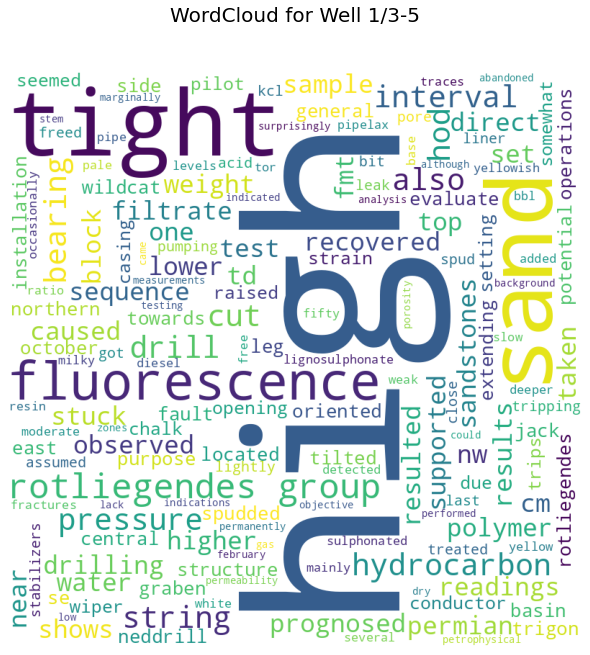

In [49]:
# plot the WordCloud image

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title(label="WordCloud for Well 1/3-5\n\n",
             fontsize = 20,
             color = "black")

plt.show()

---

## Processing all summaries
We are going to use 'bag_of_words_no_stop' which we created above. It's a list of list, where every element is a bag of word for each summary.

In [50]:
type(bag_of_words_no_stop)

list

In [51]:
len(bag_of_words_no_stop)

1824

# Warning, this path needs changing for each user! [comment]

# And potentially also the version. check spacy installation guide [comment]

# Need to run `python -m spacy download en_core_web_sm` after installing spacy [comment]

In [54]:
path_spacey_model = '/home/geodev/anaconda3/envs/nlp_test/lib/python3.8/site-packages/en_core_web_sm/en_core_web_sm-3.0.0' # path to our Spacey language model

In [55]:
# spaCy NLP library:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.1.0/en_core_web_sm-2.1.0.tar.gz
# github repo here: https://github.com/explosion/spacy-models

nlp = spacy.load(path_spacey_model, disable=['parser', 'ner']) # --> after running pip install in your github repo home directory, load the model

In [56]:
# Reducing the term count - FIRST STEP

# We have already removed our stop words (see above)

# The lemmatization will allow us to select a specific type of word, for instance 'NOUN'

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [57]:
bag_of_words_no_stop_lemma = lemmatization(bag_of_words_no_stop, allowed_postags=['NOUN'])

# weird, text leaking off page again in print output, and in most places actually [comment]

In [58]:
print(bag_of_words_no_stop_lemma[:1]) # --> I think it would be better to process WORDCLOUD on the lemmatization texts!

[['graben', 'border', 'north', 'sea', 'paleocene', 'sand', 'rogaland', 'group', 'chalk', 'formation', 'operation', 'result', 'wildcat', 'installation', 'isle', 'tor', 'cutting', 'elevator', 'string', 'attempt', 'recover', 'string', 'success', 'seawater', 'water', 'clay', 'borehole', 'seawater', 'gas', 'forty', 'hydrocarbon', 'bearing', 'log', 'rft', 'pressure', 'gradient', 'sandstone', 'forty', 'property', 'porosity', 'test', 'permeability', 'md', 'core', 'rft', 'data', 'water', 'gradient', 'oil', 'shift', 'psi', 'existence', 'barrier', 'saturation', 'fluorescence', 'existence', 'oil', 'barrier', 'log', 'test', 'lack', 'datum', 'point', 'ekofisk', 'tor', 'formation', 'water', 'core', 'forty', 'sidetrack', 'wire', 'line', 'fluid', 'sample', 'june', 'oil', 'gas', 'discovery', 'interval', 'intention', 'test', 'oil', 'produce', 'sample', 'water', 'interval', 'oil', 'water', 'oil', 'test', 'oil', 'gas', 'day', 'oil', 'gravity', 'deg', 'api', 'temperature', 'test', 'analysis', 'co', 'oil', '

In [59]:
mylist = bag_of_words_no_stop_lemma[:1]
myflatlist = []
for sublist in mylist:
    for item in sublist:
        myflatlist.append(item)

In [60]:
len(myflatlist)

109

In [61]:
print(bag_of_words_no_stop[:1]) # let's have a look at the same example BEFORE lemmatization

[['general', 'located', 'central', 'graben', 'uk', 'border', 'north', 'sea', 'main', 'objective', 'paleocene', 'sands', 'rogaland', 'group', 'secondary', 'chalk', 'formations', 'although', 'possibly', 'enough', 'fractured', 'represent', 'operations', 'results', 'wildcat', 'spudded', 'semi', 'submersible', 'installation', 'ross', 'isle', 'march', 'td', 'late', 'cretaceous', 'tor', 'cutting', 'elevators', 'accidentally', 'opened', 'dropped', 'string', 'two', 'attempts', 'made', 'recover', 'string', 'success', 'sidetracked', 'cut', 'seawater', 'native', 'water', 'mixed', 'clays', 'borehole', 'seawater', 'td', 'shallow', 'gas', 'detected', 'forties', 'came', 'hydrocarbon', 'bearing', 'confirmed', 'electric', 'logs', 'rft', 'pressure', 'gradient', 'sandstones', 'forties', 'showed', 'good', 'excellent', 'properties', 'average', 'porosity', 'test', 'permeability', 'measured', 'md', 'shows', 'cores', 'recorded', 'gradually', 'decreased', 'zero', 'rft', 'data', 'two', 'water', 'gradients', 'ide

In [62]:
# Inspect most frequent terms

def detoken(texts):
    """detokenizer"""
    texts_out = []
    for sent in texts:
        texts_out.append(" ".join(s for s in sent))
    return texts_out

bag_of_words_no_stop_lemma_test = detoken(bag_of_words_no_stop_lemma)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(bag_of_words_no_stop_lemma_test)
freq = np.ravel(X.sum(axis=0)) 

vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
fdist = dict(zip(vocab, freq))

# Save all terms as CSV file to inspect all

with open('term_dict.csv', 'w', encoding='utf-8') as f:
    for key in fdist.keys():
        f.write("%s,%s\n"%(key,fdist[key]))

In [63]:
# Create a document-term-matrix (DTM) --> this is going to be used in the topic modelling function below

# Create Dictionary
id2word = Dictionary(bag_of_words_no_stop_lemma)
print("Length of initial dictionary is: ", (len(id2word)))

id2word.filter_extremes(no_below=5, no_above=0.5)
print("Length of reduced dictionary is: ", (len(id2word)))

# Create Corpus
texts = bag_of_words_no_stop_lemma

# Term Document Frequency
corpus1 = [id2word.doc2bow(text) for text in texts]

# View
print(corpus1[:1])
print(id2word)

Length of initial dictionary is:  3845
Length of reduced dictionary is:  1440
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 2), (21, 3), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 2), (55, 1)]]
Dictionary(1440 unique tokens: ['analysis', 'api', 'attempt', 'barrier', 'bearing']...)


In [64]:
# Find low term documents and remove (less than 3 terms per document) --> could be an idea to remove all texts which have less than 10 or so?

# Convert corpus to a numpy matrix
numpy_matrix = gensim.matutils.corpus2dense(corpus1, num_terms=len(id2word)) # adjust based on length of dictionary

# Create a filtered matrix that removes docs with less than 3 terms
n_matrix2 = numpy_matrix[:, (numpy_matrix != 0).sum(axis=0) > 2]

# Convert matrix back to a corpus
corpus = gensim.matutils.Dense2Corpus(n_matrix2)

# Confirm change has been made
print(len(corpus1)) # original corpus
print(len(corpus)) # new corpus

1824
1823


---

## Topic modeling
Uncovering the hidden or latent topics across a set of documents.
--> EXPLAIN HERE what are coherence values for!

In [65]:
# Function to generate the topic model

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    alpha = [0.1, 1, 10]
    random_seed = [32, 64]
    coherence_values = []
    model_list = []
    output_list = []
    for num_topics in range(start, limit, step):
        for a in alpha:
            for r in random_seed:
                model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=r, alpha=a, workers=3)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append(coherencemodel.get_coherence())
                model_output ={'alpha': a, 'random_seed': r, 'coherence': coherencemodel.get_coherence(), 'num_topics': num_topics}
                output_list.append(model_output)
              
    return model_list, coherence_values, output_list

In [66]:
model_list, coherence_values, output_list = compute_coherence_values(dictionary=id2word,
                                                                     corpus=corpus1, texts=texts, start=4, limit=18, step=2)

In [67]:
# Inspect the models

output_list_descending = sorted(output_list, key=lambda d: d['coherence'], reverse=True)
pprint(output_list_descending)

[{'alpha': 10,
  'coherence': 0.32185643522428964,
  'num_topics': 4,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.3200369302355235,
  'num_topics': 4,
  'random_seed': 32},
 {'alpha': 0.1,
  'coherence': 0.31920332378511085,
  'num_topics': 4,
  'random_seed': 64},
 {'alpha': 1,
  'coherence': 0.31898645709570767,
  'num_topics': 4,
  'random_seed': 32},
 {'alpha': 0.1,
  'coherence': 0.3162594578844708,
  'num_topics': 10,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.3146450529853303,
  'num_topics': 6,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.3145289803892922,
  'num_topics': 8,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.3138514658403727,
  'num_topics': 10,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.31378266813971245,
  'num_topics': 6,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.3134910519881019,
  'num_topics': 14,
  'random_seed': 64},
 {'alpha': 1,
  'coherence': 0.3132771417109819,
  'num_topics': 6,
  'random_se

# in the 'explain here' sections, if pertinent it's worth showing links to other pages or resources, if you do, include the link in this notebook too [comment]

#### EXPLAIN HERE what is LDA model and Perplexity!

In [68]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus1,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [69]:
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"pressure" + 0.026*"contact" + 0.025*"prospect" + 0.021*"sidetrack" + '
  '0.019*"appraisal" + 0.018*"quality" + 0.017*"field" + 0.015*"formation" + '
  '0.013*"nbsp" + 0.013*"column"'),
 (1,
  '0.070*"dst" + 0.057*"day" + 0.044*"temperature" + 0.040*"brent" + '
  '0.034*"gravity" + 0.029*"flow" + 0.024*"cm" + 0.023*"density" + '
  '0.023*"rate" + 0.021*"statfjord"'),
 (2,
  '0.037*"rock" + 0.023*"source" + 0.022*"stø" + 0.021*"shale" + '
  '0.021*"claystone" + 0.020*"age" + 0.020*"sequence" + 0.019*"section" + '
  '0.017*"analysis" + 0.017*"fluorescence"'),
 (3,
  '0.090*"sandne" + 0.062*"garn" + 0.059*"bryne" + 0.055*"formation" + '
  '0.033*"lange" + 0.031*"tilje" + 0.030*"structure" + 0.030*"yme" + '
  '0.030*"fangst" + 0.024*"chalk"'),
 (4,
  '0.050*"sand" + 0.026*"section" + 0.023*"drilling" + 0.018*"seawater" + '
  '0.018*"log" + 0.015*"structure" + 0.014*"depth" + 0.012*"jurassic" + '
  '0.011*"porosity" + 0.010*"block"')]


In [70]:
# lda_model.show_topics()

In [71]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.169878441333352


In [72]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=bag_of_words_no_stop_lemma, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4296407737025045


# again sure you will, but this chart needs explaining, and a good place to finish on. [comment]

In [73]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.095456  0.056419       1        1  34.691152
0     -0.076600 -0.055356       2        1  25.799032
1      0.010483 -0.301452       3        1  16.936943
2     -0.196342  0.186210       4        1  16.918916
3      0.357914  0.114179       5        1   5.653956, topic_info=               Term         Freq        Total Category  logprob  loglift
98              dst  1372.000000  1372.000000  Default  30.0000  30.0000
46             sand  2050.000000  2050.000000  Default  29.0000  29.0000
14              day  1280.000000  1280.000000  Default  28.0000  28.0000
576          sandne   592.000000   592.000000  Default  27.0000  27.0000
20        formation  1184.000000  1184.000000  Default  26.0000  26.0000
53      temperature   865.000000   865.000000  Default  25.0000  25.0000
761           brent   778.000000   778.000000  Default  24.0000  24.0000
121            rock   719.000000   719.000000  Default  23.0000  23.0000
24          gravity   670.000000   670.000000  Default  22.0000  22.0000
1367           garn   405.000000   405.000000  Default  21.0000  21.0000
244           bryne   390.000000   390.000000  Default  20.0000  20.0000
81        structure  1220.000000  1220.000000  Default  19.0000  19.0000
10          contact  1124.000000  1124.000000  Default  18.0000  18.0000
152            flow   599.000000   599.000000  Default  17.0000  17.0000
50        sidetrack   641.000000   641.000000  Default  16.0000  16.0000
146              cm   478.000000   478.000000  Default  15.0000  15.0000
131          source   458.000000   458.000000  Default  14.0000  14.0000
142       appraisal   913.000000   913.000000  Default  13.0000  13.0000
117            rate   455.000000   455.000000  Default  12.0000  12.0000
1412            stø   433.000000   433.000000  Default  11.0000  11.0000
141             air   414.000000   414.000000  Default  10.0000  10.0000
168       claystone   412.000000   412.000000  Default   9.0000   9.0000
367           shale   743.000000   743.000000  Default   8.0000   8.0000
148         density   504.000000   504.000000  Default   7.0000   7.0000
765       statfjord   561.000000   561.000000  Default   6.0000   6.0000
77         prospect   962.000000   962.000000  Default   5.0000   5.0000
127        sequence   539.000000   539.000000  Default   4.0000   4.0000
15              deg   414.000000   414.000000  Default   3.0000   3.0000
1359          lange   215.000000   215.000000  Default   2.0000   2.0000
62       condensate   434.000000   434.000000  Default   1.0000   1.0000
89           casing   361.690957   362.494117   Topic1  -4.7132   1.0565
87              bit   270.908279   271.730660   Topic1  -5.0022   1.0557
656        platform   234.213246   235.036080   Topic1  -5.1478   1.0552
285             set   194.113505   194.925505   Topic1  -5.3355   1.0545
90           cement   188.791463   189.597793   Topic1  -5.3633   1.0544
631         chamber   186.248524   187.061068   Topic1  -5.3769   1.0543
2           attempt   155.938639   156.748881   Topic1  -5.5545   1.0535
425             bop   141.072857   141.961425   Topic1  -5.6547   1.0524
329         epsilon   133.090001   134.053903   Topic1  -5.7130   1.0515
723          gallon   112.454068   113.273468   Topic1  -5.8814   1.0514
281         miocene   108.643609   109.447270   Topic1  -5.9159   1.0513
114            plug   108.005721   108.805740   Topic1  -5.9218   1.0513
785        spersene   110.980352   111.809830   Topic1  -5.8946   1.0512
357        increase   105.982119   106.798410   Topic1  -5.9407   1.0510
548           delta   101.989434   102.797957   Topic1  -5.9791   1.0508
113            pipe   199.561527   201.200722   Topic1  -5.3079   1.0505
34        paleocene   290.836119   293.428882   Topic1  -4.9312   1.0498
643            anco    87.620680    88.440113   Topic1  -6.1310   1.0494
11

In [ ]:
%cd /Users/anne/Desktop/Github_repo/NLP_Transform21/notebooks

In [ ]:
%pwd

---

In [ ]:
# Write df_all_summaries and df_all_with_coord into a CSV file to have a backup...
# df_all_summaries.to_csv(index=False)
# df_all_with_coord.to_csv(index=False)